Import the needed packages and ml modules 

In [1]:
import numpy as np
import pandas as pd

import xarray as xr
import os
import sys

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchsummary import summary
from sklearn.model_selection import KFold
import torch.nn.functional as F
from sklearn.metrics import r2_score

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 

import folium
import folium.plugins
import pandas as pd
import xarray as xr
import branca
import branca.colormap as cm


Read input

In [2]:
# input data
t_array = np.memmap('../data/processed/t_CT.dat',
                mode='r+',
                dtype=float,
                shape=(1197, 9, 480))

# move time axis to the middle
t_array = np.moveaxis(t_array, 2, 1)


print('all:',t_array.shape)
data = t_array[:int(len(t_array)*0.65)]
test_data = t_array[int(len(t_array)*0.65):]
print('train:',data.shape)
print('test:',test_data.shape)

all: (1197, 480, 9)
train: (778, 480, 9)
test: (419, 480, 9)


Autoencoder model for offshore time series

In [3]:
torch.manual_seed(0)
# (1) Encoder
class Encoder(nn.Module):
    def __init__(self, seq_len, no_features, embedding_size):
        super().__init__()
        
        self.seq_len = seq_len
        self.no_features = no_features    # The number of expected features(= dimension size) in the input x
        self.embedding_size = embedding_size   # the number of features in the embedded points of the inputs' number of features
        self.hidden_size = (2 * embedding_size)  # The number of features in the hidden state h
        self.LSTM1 = nn.LSTM(
            input_size = no_features,
            hidden_size = embedding_size,
            num_layers = 1,
            batch_first=True
        )
        
    def forward(self, x):
        # Inputs: input, (h_0, c_0). -> If (h_0, c_0) is not provided, both h_0 and c_0 default to zero.
        x, (hidden_state, cell_state) = self.LSTM1(x)  
        last_lstm_layer_hidden_state = hidden_state[-1,:,:]
        return last_lstm_layer_hidden_state
    
    
# (2) Decoder
class Decoder(nn.Module):
    def __init__(self, seq_len, no_features, output_size):
        super().__init__()

        self.seq_len = seq_len
        self.no_features = no_features
        self.hidden_size = (2 * no_features)
        self.output_size = output_size
        self.LSTM1 = nn.LSTM(
            input_size = no_features,
            hidden_size = self.hidden_size,
            num_layers = 1,
            batch_first = True
        )

        self.fc = nn.Linear(self.hidden_size, output_size)
        
    def forward(self, x):
        x = x.unsqueeze(1).repeat(1, self.seq_len, 1)
        x, (hidden_state, cell_state) = self.LSTM1(x)
        x = x.reshape((-1, self.seq_len, self.hidden_size))
        out = self.fc(x)
        return out
    
# (3) Autoencoder : putting the encoder and decoder together
class LSTM_AE(nn.Module):
    def __init__(self, seq_len, no_features, embedding_dim):
        super().__init__()
        
        self.seq_len = seq_len
        self.no_features = no_features
        self.embedding_dim = embedding_dim

        self.encoder = Encoder(self.seq_len, self.no_features, self.embedding_dim)
        self.decoder = Decoder(self.seq_len, self.embedding_dim, self.no_features)
           
    def forward(self, x):

        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded,encoded
    

In [4]:
def trainAE(num_folds,batch_size,nepochs,lr,t,n,z): #
    print('Training Autoencoder of t,n,z :',t,n,z)
    
    if num_folds >1:
        print('Using K-fold Cross Validation')

        # Define k-fold indices
        kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
        splits = kf.split(data)

        # Loop over folds
        fold_losses = [] 
        for idx, (train_idx, val_idx) in enumerate(splits):
            t_epoch_losses = []
            es_epoch_losses = []
            # Split data into train and validation sets
            x_train, x_val = data[train_idx], data[val_idx]

            # Create PyTorch DataLoader objects
            train_dataset = torch.utils.data.TensorDataset(torch.Tensor(x_train))
            train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

            val_dataset = torch.utils.data.TensorDataset(torch.Tensor(x_val))
            val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

            # Initialize model, optimizer, and loss function
            model = LSTM_AE(seq_len = 480, no_features = n ,embedding_dim = z) 
            model.to('cuda')
            optimizer = torch.optim.Adam(model.parameters(), lr=lr)
            criterion = nn.MSELoss()

            # Train model
            for epoch in range(nepochs):
                train_loss = 0
                es_losses = 0
                for batch_idx, (batch_data,) in enumerate(train_loader):
                    optimizer.zero_grad()
                    batch_data = batch_data.to('cuda')
                    recon_data, latent = model(batch_data) 
                    loss = criterion(recon_data, batch_data)
                    train_loss += loss.item()
                    loss.backward()
                    optimizer.step()
                
                for batch_idx, (batch_data,) in enumerate(val_loader):
                    batch_data = batch_data.to('cuda')
                    recon_data, latent = model(batch_data) 
                    loss = criterion(recon_data, batch_data)
                    es_losses += loss.item()

                print(f"Fold {idx + 1},epoch:{epoch},training loss: {train_loss / len(train_loader):.5f},val loss: {es_losses / len(val_loader):.5f}", end="\r")
                
                t_epoch_losses.append(train_loss / len(train_loader))
                es_epoch_losses.append(es_losses / len(val_loader))
            
            #plot training/val loss
            plt.plot(t_epoch_losses, color='blue')
            plt.plot(es_epoch_losses, color='red')
            plt.title(f"Training loss for fold {idx + 1}")
            plt.xlabel("Epoch")
            plt.ylabel("Loss")
            plt.yscale('log')
            plt.savefig(f"./../model/{reg}/plot/fold{idx + 1}_training_loss.png")   
            plt.clf()

            print(f"Fold {idx + 1},epoch:{epoch},training loss: {train_loss / len(train_loader):.5f}")    
            
            # Validation model
            model.eval()
            with torch.no_grad():
                val_loss = 0
                for batch_idx, (batch_data,) in enumerate(val_loader):
                    batch_data = batch_data.to('cuda')
                    recon_data, latent = model(batch_data) 
                    loss = criterion(recon_data, batch_data)
                    val_loss += loss.item()
            print(f"Fold {idx + 1}, validation loss: {val_loss / len(val_loader):.5f}")
            #save fold loss
            fold_losses.append(val_loss / len(val_loader))
            
        #average validation loss accross folds
        print(f"Average validation loss: {np.mean(fold_losses):.5f} for zdim = {z}")
        #save model
        torch.save(model, f"./../model/{reg}/out/model_offshore_zdim_{z}")

    elif num_folds == 0:
  
        # Create PyTorch DataLoader objects
        train_dataset = torch.utils.data.TensorDataset(torch.Tensor(data[0:int(len(data)*0.99)]))   
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
        val_dataset = torch.utils.data.TensorDataset(torch.Tensor(data[int(len(data)*0.99):]))
        val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        test_dataset = torch.utils.data.TensorDataset(torch.Tensor(test_data))
        test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        # Initialize model, optimizer, and loss function
        model = LSTM_AE(seq_len = t, no_features = n ,embedding_dim = z)
        model.to('cuda')
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        criterion = nn.MSELoss()

        t_epoch_losses = []
        es_epoch_losses = []
        test_epoch_losses = []

        # Train model
        for epoch in range(nepochs):
            train_loss = 0
            es_losses = 0
            test_loss = 0
            for batch_idx, (batch_data,) in enumerate(train_loader):
                optimizer.zero_grad()
                batch_data = batch_data.to('cuda')
                recon_data, latent = model(batch_data) 
                loss = criterion(recon_data, batch_data)
                train_loss += loss.item()
                loss.backward()
                optimizer.step()
                    
            for batch_idx, (batch_data,) in enumerate(val_loader):
                batch_data = batch_data.to('cuda')
                recon_data, latent = model(batch_data) 
                vloss = criterion(recon_data, batch_data)
                es_losses += vloss.item()
            
            for batch_idx, (batch_data,) in enumerate(test_loader):
                batch_data = batch_data.to('cuda')
                recon_data, latent = model(batch_data) 
                tloss = criterion(recon_data, batch_data)
                test_loss += tloss.item()

            print(f"NoFold,epoch:{epoch},training loss: {train_loss / len(train_loader):.5f},val loss: {es_losses / len(val_loader):.5f},test loss:{test_loss / len(test_loader):.5f}", end="\r")
            
            t_epoch_losses.append(train_loss / len(train_loader))
            es_epoch_losses.append(es_losses / len(val_loader))
            test_epoch_losses.append(test_loss / len(test_loader))
            
            #plot training/val loss
            plt.plot(t_epoch_losses, color='blue')
            plt.plot(es_epoch_losses, color='red')
            plt.plot(test_epoch_losses, color='green')
            plt.legend(['train', 'val', 'test'], loc='upper left')
            plt.title(f"Training loss for Nofold")
            plt.xlabel("Epoch")
            plt.ylabel("Loss")
            plt.yscale('log')
            plt.savefig(f"./../model/{reg}/plot/offshore_Nofold_loss_z_{z}_LSTM.png")   
            plt.clf()

            if epoch % 100 == 0 and epoch >= 800:
                #save model
                torch.save(model, f"./../model/{reg}/out/model_offshore_z_{z}_epoch_{epoch}_LSTM")
    
    with open(f"./../model/{reg}/out/model_offshore_ch_loss.txt", "a") as text_file:
        text_file.write(f"LSTM z:{z}, train loss: {t_epoch_losses[-1]}, val loss: {es_epoch_losses[-1]}, test loss: {test_loss / len(test_loader):.5f}\n")
    text_file.close()   


In [5]:
reg = 'CT'
#create regional folders
if not os.path.exists(f"./../model/{reg}/out/"):
    os.makedirs(f"./../model/{reg}/out/")
if not os.path.exists(f"./../model/{reg}/plot/"):
    os.makedirs(f"./../model/{reg}/plot/")

n = data.shape[2]
t = data.shape[1]
batch_size = 50
num_epochs = 1001
learning_rate = 0.01
num_folds = 0
z = 64

# trainAE(num_folds,batch_size,num_epochs,learning_rate,t,n,z)

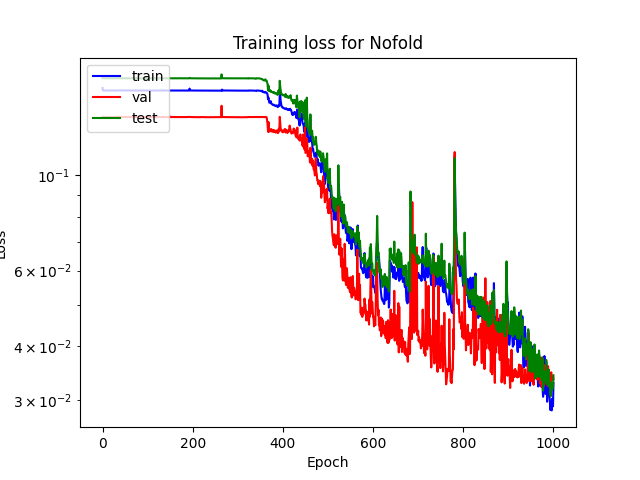

In [6]:
#open image file
from PIL import Image
img = Image.open(f'./../model/{reg}/plot/offshore_Nofold_loss_z_{z}_LSTM.png')
img

In [19]:
#read model from file
model = torch.load(f"./../model/{reg}/out/model_offshore_z_{z}_epoch_1000_LSTM")
# summary(model,(t,n))
model.eval()
# Test model for final evaluation
criterion = nn.MSELoss()
print(test_data.shape)
# test_dataset = torch.tensor(test_data, dtype=torch.float32).to('cuda')
# print(test_dataset.shape)
# recon_data, latent = model(test_dataset)
# tloss = criterion(recon_data, test_dataset)
# print(f"Test loss: {tloss :.5f}", end="\r")

test_loss = 0
recon_data = []
test_dataset = torch.utils.data.TensorDataset(torch.Tensor(test_data))
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
for batch_idx, (batch_data,) in enumerate(test_loader):
    batch_data = batch_data.to('cuda')
    out_recon_data, latent = model(batch_data) 
    tloss = criterion(out_recon_data, batch_data)
    test_loss += tloss.item()
    recon_data.append(out_recon_data.cpu().detach().numpy())

recon_data = np.concatenate(recon_data)
print(f"Test loss: {test_loss / len(test_loader):.5f}", end="\r")

(419, 480, 9)


(419, 480, 9)


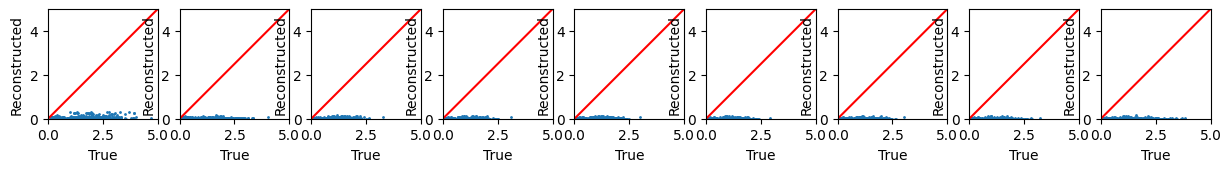

In [22]:
# Plot results all gauge max for all events
recon_data =  np.moveaxis(recon_data, 2, 1)
test_data = np.moveaxis(test_data, 2, 1)

print(recon_data.shape)

plt.figure(figsize=(15, 3))
for g in range(9):
    plt.subplot(1, 9, g+1)
    plt.scatter(test_data[:, g, :].max(axis=1), recon_data[:, g, :].max(axis=1), s=1)
    plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes, color='red')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.xlim(0, 5)
    plt.ylim(0, 5)
    plt.xlabel('True')
    plt.ylabel('Reconstructed')
plt.show()



In [23]:
all_ids = np.loadtxt('../data/events/shuffled_events_CT.txt', dtype='str',skiprows=0)
test_ids = all_ids[int(len(all_ids)*0.65):]
eve_info = pd.read_csv('../data/info/about_alleve1212_PS.txt', sep='\t')

#check performance per event for each gauge
eve_perf = []
for eve_no,eve in enumerate(test_ids):
    eve_perf.append([eve_no,r2_score(test_data[eve_no, 0, :], recon_data[eve_no, 0, :]),
                                r2_score(test_data[eve_no, 1, :], recon_data[eve_no, 1, :]),
                                r2_score(test_data[eve_no, 2, :], recon_data[eve_no, 2, :]),
                                r2_score(test_data[eve_no, 3, :], recon_data[eve_no, 3, :]),
                                r2_score(test_data[eve_no, 4, :], recon_data[eve_no, 4, :]),
                                r2_score(test_data[eve_no, 5, :], recon_data[eve_no, 5, :]),
                                r2_score(test_data[eve_no, 6, :], recon_data[eve_no, 6, :]),
                                r2_score(test_data[eve_no, 7, :], recon_data[eve_no, 7, :]),
                                r2_score(test_data[eve_no, 8, :], recon_data[eve_no, 8, :]),
                                ])

#count of events less than 
eve_perf = np.array(eve_perf)

#add column with average r2 score
eve_perf = np.append(eve_perf, np.mean(eve_perf[:,1:], axis=1).reshape(-1,1), axis=1)

print(eve_perf[eve_perf[:,10]<0.9].shape[0])

ValueError: Found input variables with inconsistent numbers of samples: [480, 9]

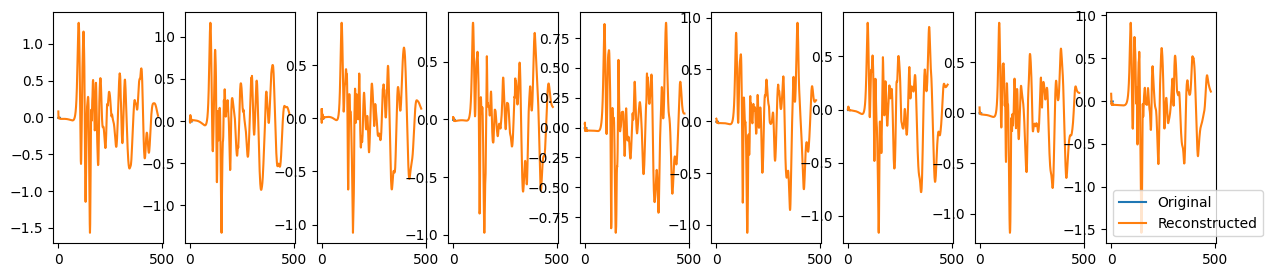

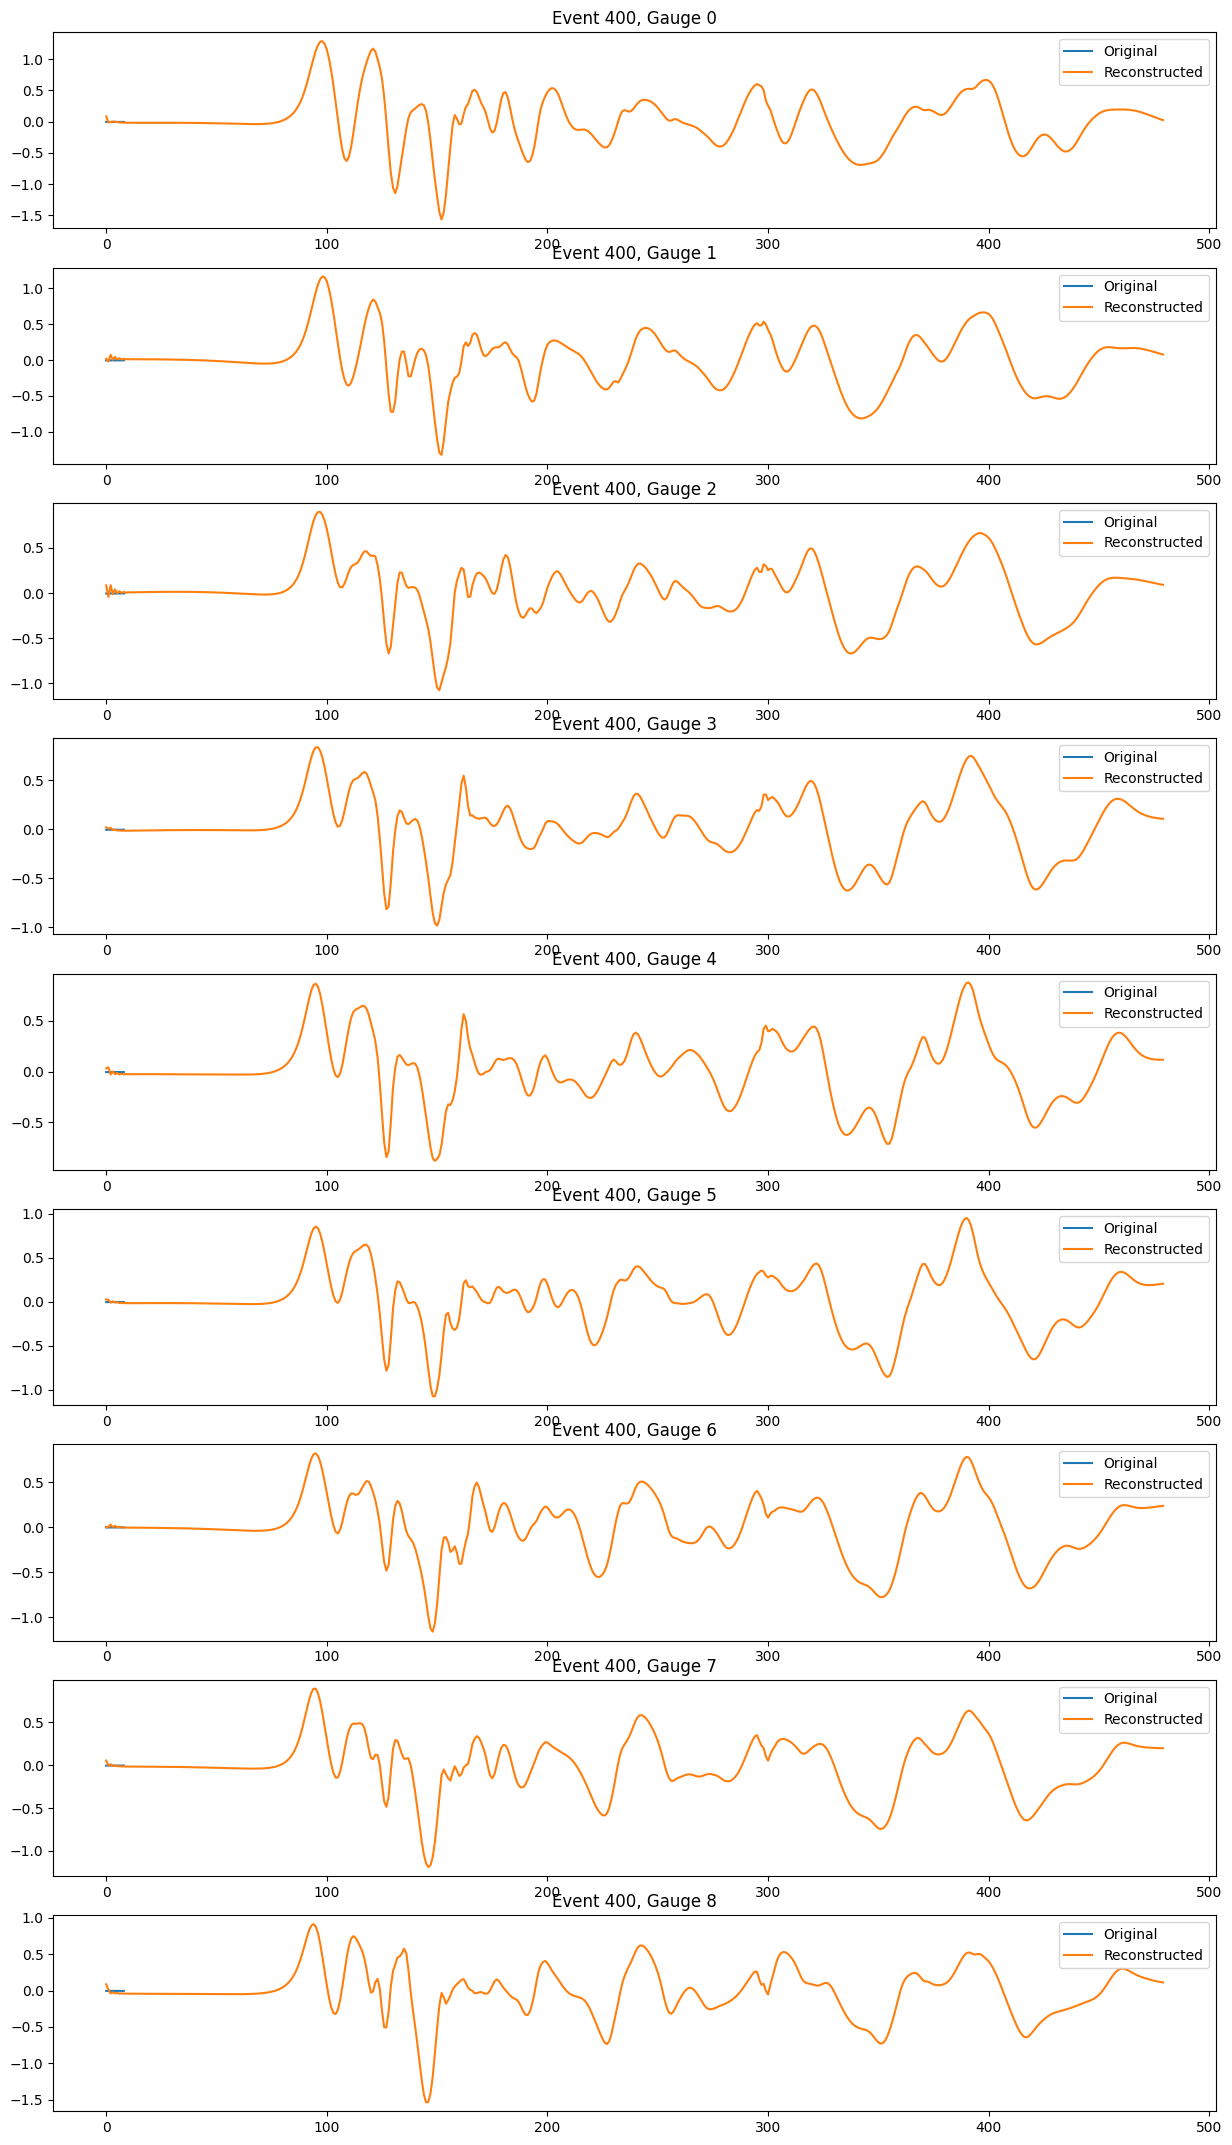

In [21]:
# Plot results all gauge
eve_no = 400
plt.figure(figsize=(15, 3))
for g in range(9):
    plt.subplot(1, 9, g+1)
    plt.plot(test_data[eve_no, g, :], label="Original")
    plt.plot(recon_data[eve_no, g, :], label="Reconstructed")
plt.legend()
plt.show()

# Plot results for all gauges for one event row wise
plt.figure(figsize=(15, 27))
for g in range(9):
    plt.subplot(9, 1, g+1)
    plt.title(f"Event {eve_no}, Gauge {g}")
    plt.plot(test_data[eve_no, g, :], label="Original")
    plt.plot(recon_data[eve_no, g, :], label="Reconstructed")
    plt.legend()
plt.show()

# plt.plot(test_data[eve_no, 8, :], label="Original")
# plt.plot(recon_data[eve_no, 8, :], label="Reconstructed")
# plt.legend()
# plt.show()